In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.rcParams['figure.figsize'] = (6,6)
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams["image.origin"] = 'lower'

In [1]:
config = {
    "base_dir":        "/storage/vbsjjlnu/VBSjjlnu_v7/",
    "plot_config":     "FullRun2_v7",
    "cut":             "boost_sig",
    "model_version":   "v24",
    "model_tag":       "5l_64n_l2_batchnorm_relu",
    "samples_version": "v1",
    "cols": [
        "Lepton_pt",
        "Lepton_eta",
        "nJets30",
        "vbs_0_pt",
        "vbs_1_pt",
        "vjet_0_pt",
        "vjet_0_eta",
        "mjj_vbs",
        "mjj_vjet",
        "deltaeta_vbs",
        "deltaphi_vbs",
        "Zvjets_0",
        "Zlep",
        "Asym_vbs",
        #"w_lep_pt",
        #"w_had_pt",
        "A_ww",
        "Centr_vbs",
        "Centr_ww",
        #"fatjet_ZvsQCD",
        #"fatjet_WvsQCD",
        #"fatjet_subjet1_pt",
        #"fatjet_subjet2_pt",
        "vbs_0_qgl_boost",
        "vbs_1_qgl_boost",
        ],    
    "test_size": 0.2,
    "val_size":  0.0,
    "optimizer": "adam",
    "batch_size": 1024,
    "decay_weights": True,
    "decay_weights_pars" : [0.003,3,0.3]
}

import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

In [49]:
len(config["cols"])

19

```.python
# config examples
"cut":             "boos_sig_mjjincl",
"cut":             "res_sig_mjjincl",
"model_tag":       "res_4depth_v0",
"model_tag":       "boost_5vars_v0",
 ```

In [3]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [4]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [6]:
## instead of reading the variables from file,
## we now set the variables here, and then dump them
# import yaml
# yaml_vars = yaml.safe_load(open(os.path.join(model_dir, "variables.yml")))
# print("yaml: ", type(yaml_vars), len(yaml_vars))
# cols = yaml_vars

In [7]:
bkg.columns[bkg.isnull().any()] 

Index([], dtype='object')

In [8]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight"]).values
Wnn_bkg = (bkg["weight"]).values

In [9]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

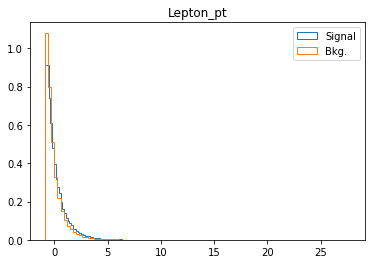

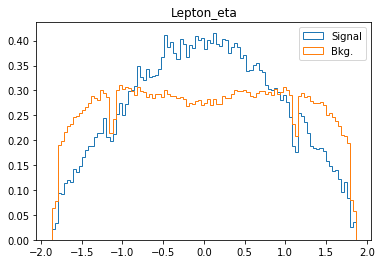

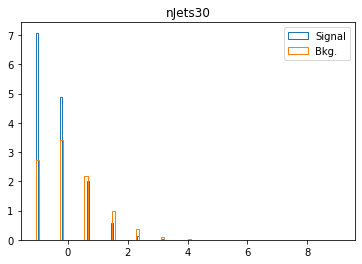

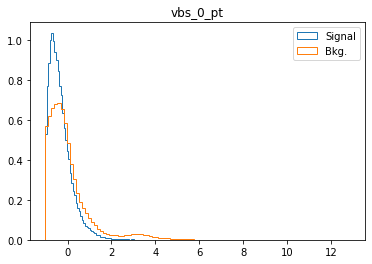

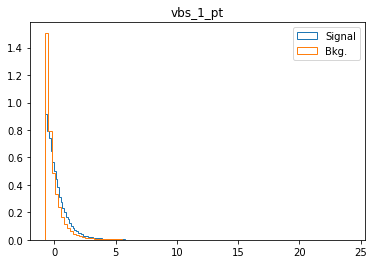

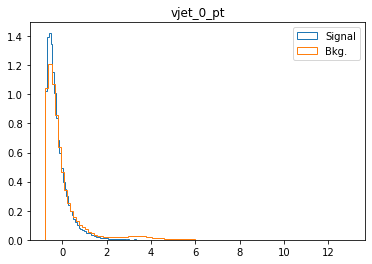

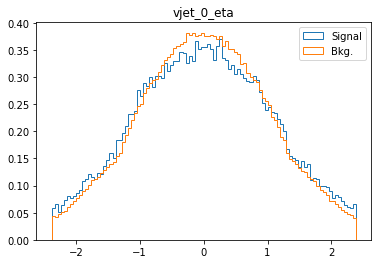

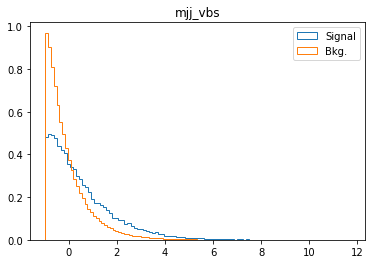

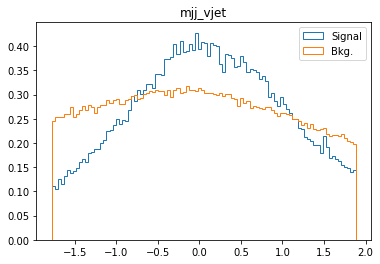

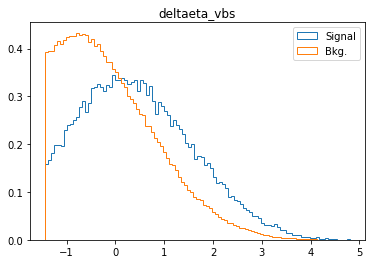

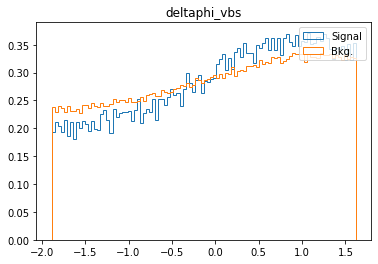

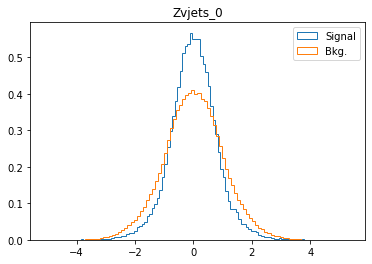

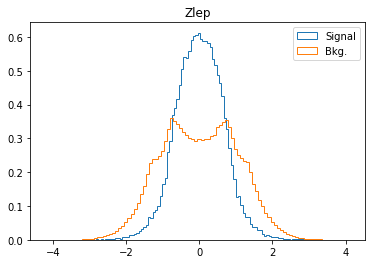

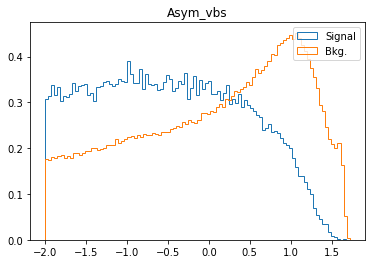

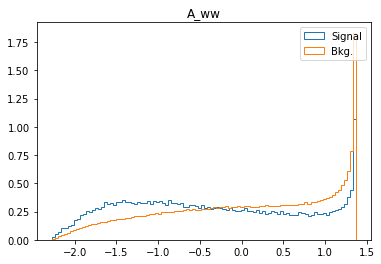

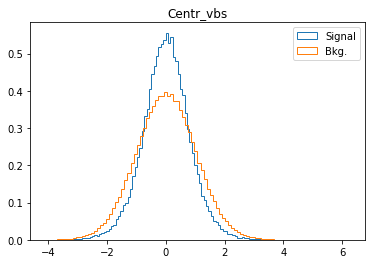

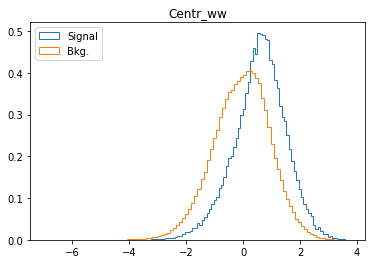

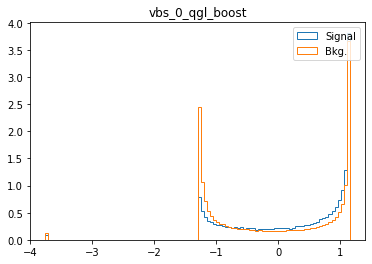

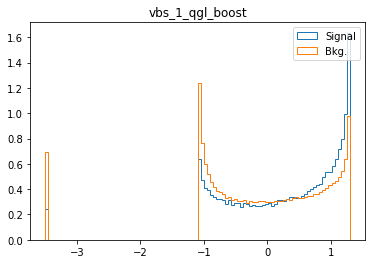

In [68]:
## draw weights and input variables in order to spot any importing error

for idx,col in enumerate(config["cols"]):
    
    _ = plt.hist(X_scaled[Y==1,idx], bins=100, histtype="step", density=True, label="Signal")
    _ = plt.hist(X_scaled[Y==0,idx], bins=100, histtype="step", density=True, label="Bkg.")
    plt.legend()
    plt.title(col)
    plt.show()

##  Balancing


In [86]:
X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = \
            train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"], random_state=42, stratify=Y)


#X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=config["val_size"]) ## test != val

In [74]:
print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_test.shape)
#print("Testing    dataset: ", X_test.shape)
#print("Validation dataset: ", X_val.shape)

Training   dataset:  (383402, 19)
Test + Val dataset:  (95851, 19)


Create generators to balance signal and background

## Keras model

In [15]:
%load_ext autoreload


In [16]:
%autoreload 2

In [140]:
# import local module that programmatically returns keras models
import dnn_models_v2

print(config["model_tag"])
model = dnn_models_v2.get_model(config["model_tag"], X_train.shape[1])

model.compile(optimizer=config["optimizer"],
            loss='binary_crossentropy',
            metrics=['accuracy'])



model.summary()

5l_64n_l2_batchnorm_relu
>>> Creating model...
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 128)               2560      
_________________________________________________________________
activation_80 (Activation)   (None, 128)               0         
_________________________________________________________________
batch_normalization_81 (Batc (None, 128)               512       
_________________________________________________________________
dense_105 (Dense)            (None, 64)                8256      
_________________________________________________________________
activation_81 (Activation)   (None, 64)                0         
_________________________________________________________________
batch_normalization_82 (Batc (None, 64)                256       
_________________________________________________________________
dense_

In [141]:
## import and configure the plot loss callback

import dnn_plot_loss

data = {
    "X_train": X_train,
    #"X_test" : X_test, ## test != val
    "X_val" : X_test, ## test == val
    "y_train": y_train,
    #"y_test" : y_test, ## test!= val
    "y_val" : y_test, ## test == val
    "W_train": W_train,
    #"W_test" : W_test, ## test != val
    "W_val": W_test, ## test == val
    
    "Wnn_train": Wnn_train,

    #"W_test" : W_test, ## test != val
    "Wnn_val": Wnn_test, ## test == val
}

plot_losses = dnn_plot_loss.PlotLosses(model, data, batch_mode=False)

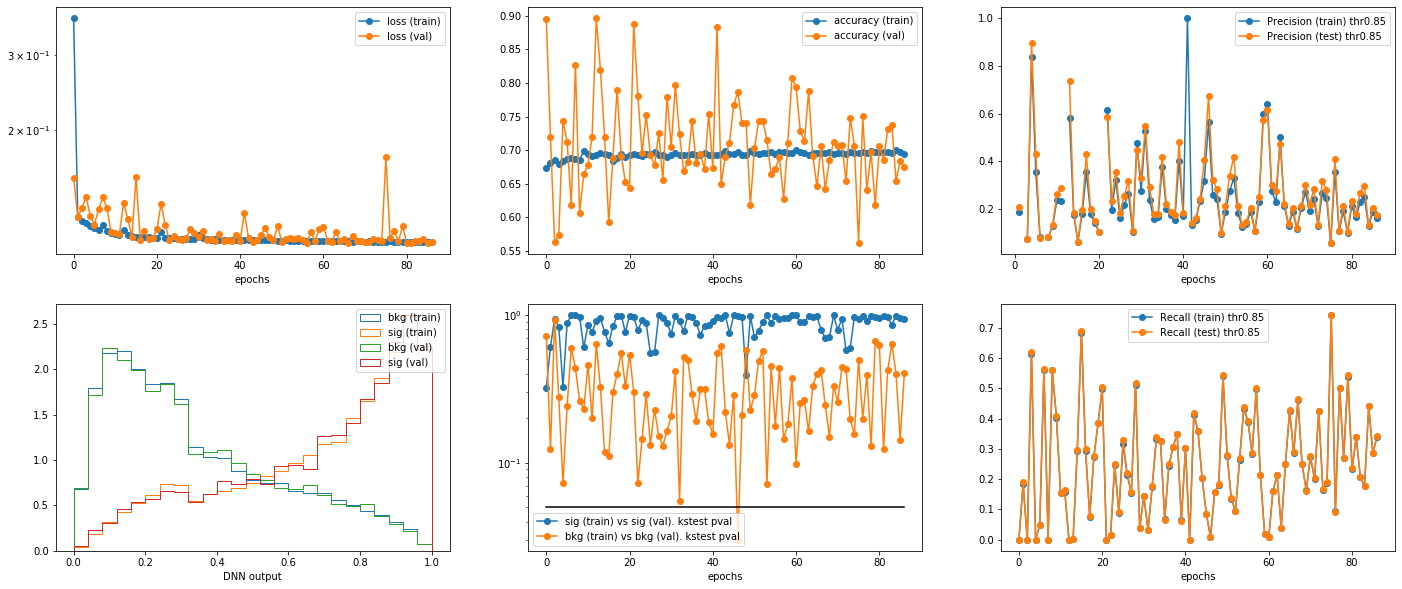

383402/383402 [==============================] - 10s 27us/sample - loss: 0.1096 - accuracy: 0.6942 - val_loss: 0.1098 - val_accuracy: 0.6746


In [142]:
## TRAINING without random sampling
import time
start_time = time.time()
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers.schedules import InverseTimeDecay

early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                            min_delta=0.0005, patience=30, verbose=0, mode='auto', 
                            baseline=None, restore_best_weights=True)

_callbacks = [plot_losses, early_stopping]

if config['decay_weights']:
    lr_scheduler = callbacks.LearningRateScheduler(InverseTimeDecay(*config["decay_weights_pars"]))
    _callbacks.append(lr_scheduler)

config["epochs"] = 200

history = model.fit(
            X_train, y_train,
            sample_weight = W_train,
            epochs=config["epochs"],
            validation_data  = (X_test, y_test, W_test),
            callbacks=_callbacks,
            shuffle = True,
            batch_size= config["batch_size"]
            #callbacks = [], 
            )

config["train_time"] = time.time() - start_time

In [143]:
## SAVE THE MODEL, ITS METADATA AND TRAINING INFORMATIONS

# dump the variables list
import yaml
varfile = os.path.join(model_dir, "variables.yml")
if os.path.isfile(varfile):
    print("ACHTUNG! variables file already existing: old file renamed with '_old'")
    os.rename(varfile, varfile[:-4] + "_old.yml")
with open(varfile, "w") as out_var_file:
    out_var_file.write(yaml.dump(config["cols"]))
    
# dump the config
config["a__model_dir"] = model_dir
model_config_file = os.path.join(model_dir, "model_config.yml")
if os.path.isfile(model_config_file):
    print("ACHTUNG! model_config_file file already existing: old file renamed with '_old'")
    os.rename(model_config_file, model_config_file[:-4] + "_old.yml")
with open(model_config_file, "w") as out_var_file:
    out_var_file.write(yaml.dump(config))  

# save figure with training summary
plot_losses.save_figure( os.path.join(model_dir, "model_train.png") )

# save keras model
model.save( os.path.join(model_dir, "model.h5") )

ACHTUNG! variables file already existing: old file renamed with '_old'
ACHTUNG! model_config_file file already existing: old file renamed with '_old'


In [11]:

args = {
    "dir": model_dir,
    "input": "model.h5",
    "output": "model.pb",
    "tf_metadata": "tf_metadata.txt",
    "input_scaler": "scaler_model.pkl",
    "output_scaler": "scaler.txt",
}


import os
import pickle

import yaml
yaml_vars = yaml.safe_load(open(os.path.join(args["dir"], "variables.yml"), "r"))

scaler = pickle.load(open(os.path.join(args["dir"], args["input_scaler"]), 'rb'))
with open(os.path.join(args["dir"], args["output_scaler"]), "w") as f:
    for var, mean, scale in zip(yaml_vars, scaler.mean_, scaler.scale_):
        f.write(var + " " + str(mean) + " " + str(scale) + "\n")


### Columns List

```.python
# resolved
    "cols": [
     "Lepton_pt",
        "Lepton_eta",
        "nJets30",
        "PuppiMET_pt",
        "vbs_0_pt",
        "vbs_1_pt",
        "vjet_0_pt",
        "vjet_1_pt",
        "mjj_vbs",
        "mjj_vjet",
        "deltaeta_vbs",
        "deltaphi_vbs",
        "deltaeta_vjet",
        #"deltaphi_vjet",
        #"deltaR_lep_vbs",
        #"deltaphi_lep_nu",
        #"deltaR_vbs",
        "deltaR_vjet",
        "Zvjets_0",
        #"Zvjets_1",
        "Zlep",
        #"Asym_vbs",
        "Mtw_lep",
        "w_had_pt",
        #"R_mw",
        #"A_ww",
        #"Centr_vbs",
        #"Centr_ww",
        "vbs_0_qgl_res",
        "vbs_1_qgl_res",
        "vjet_0_qgl_res",
        "vjet_1_qgl_res",
         ]

# boosted
    "cols": ['
        "Lepton_pt",
        "Lepton_eta",
        "nJets30",
        "vbs_0_pt",
        "vbs_1_pt",
        "vjet_0_pt",
        "vjet_0_eta",
        "mjj_vbs",
        "mjj_vjet",
        "deltaeta_vbs",
        "deltaphi_vbs",
        "Zvjets_0",
        "Zlep",
        "Asym_vbs",
        #"w_lep_pt",
        #"w_had_pt",
        "A_ww",
        "Centr_vbs",
        "Centr_ww",
        "fatjet_ZvsQCD",
        "fatjet_WvsQCD",
        #"fatjet_subjet1_pt",
        #"fatjet_subjet2_pt",
        "vbs_0_qgl_boost",
        "vbs_1_qgl_boost",
         ]

         
# OLD
    "cols": ['mjj_vbs', 'deltaeta_vbs', 
            'mjj_vjet', 
            'Lepton_pt', 'Lepton_eta' ]
    "cols": ['mjj_vbs', 
             'vbs_0_pt', 'vbs_1_pt', 
             'deltaeta_vbs', 'deltaphi_vbs', 
             'mjj_vjet', 
             'vjet_0_pt', 'vjet_1_pt', 
             'vjet_0_eta', 'vjet_1_eta', 
             'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 
         ]
```